In [ ]:
# import all libraries
import pandas as pd 
import numpy as np
from math import sqrt

import seaborn as sns
sns.set(rc={'figure.figsize':(11,5)})
import matplotlib.pyplot as plt

import sklearn
from sklearn.model_selection import train_test_split,cross_val_score,KFold,GridSearchCV
from sklearn.preprocessing import MinMaxScaler,PolynomialFeatures,scale,OrdinalEncoder
from sklearn.feature_selection import RFE,VarianceThreshold
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_squared_error, r2_score

from scipy import stats
import xgboost as xgb
import re
import warnings # supress warnings
warnings.filterwarnings('ignore')
%matplotlib inline


In [ ]:
def barplotsColumns(autos, nLower=2, nUpper=100):
    """
    Function to visualize barplots/histograms for dataframe columns based on unique value counts.
    :autos: Dataframe
    :nLower: Lower bound of variable occurrences
    :nUpper: Upper bound of variable occurrences
    :return: Shows plots and saves figure as 'hi.jpg'
    """
    # Filter columns by number of unique values
    autos = autos[[col for col in autos if autos.nunique()[col] > nLower and autos.nunique()[col] < nUpper]] 
    _, nCol = autos.shape
    nGraphRow = (nCol + 5 - 1) // 5  # Use integer division
    fig = plt.figure(num=None, figsize=(7*6, 4*nGraphRow), dpi=80, facecolor='w', edgecolor='k')
    
    for i in range(nCol):
        plt.subplot(nGraphRow, 5, i + 1)
        columnDf = autos.iloc[:, i]
        # Plot categorical vs numeric differently
        if not np.issubdtype(columnDf.dtype, np.number):
            columnDf.value_counts().plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('Counts')
        plt.title(autos.columns[i])
        
    fig.savefig('hi.jpg')
    plt.show()
    
def plot_dist(data, feature):
    """
    Function to visualize distributions of a feature based on Churn.
    :data: DataFrame containing 'Churn' column
    :feature: column name to visualize
    """
    churned = data[data['Churn'] == 1][feature]
    not_churned = data[data['Churn'] == 0][feature]
    
    sns.histplot(churned, color='red', kde=True, label='Churned')
    sns.histplot(not_churned, color='green', kde=True, label='Not Churned')
    
    plt.title(f'Distribution of {feature}')
    plt.legend()
    plt.show()

def outliers(df, variable, scale=3):
    """
    Function to calculate upper and lower bounds for outliers using mean ± scale*std
    :df: DataFrame
    :variable: Column name
    :scale: Number of standard deviations from mean
    :return: upper_limit, lower_limit
    """
    upper_limit = df[variable].mean() + scale * df[variable].std()
    lower_limit = df[variable].mean() - scale * df[variable].std()
    return upper_limit, lower_limit


In [ ]:
path = ''
data = pd.read_excel(path + 'ecommerce_churn dataset.xlsx', sheet_name='E Comm')
data_dict = pd.read_excel(path + 'ecommerce_churn dataset.xlsx', sheet_name='Data Dict')

## **I - Data analysis**


**1. Data Exploration**

In [ ]:
data_dict

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3
0,NaN,Data,Variable,Discerption
1,NaN,E Comm,CustomerID,Unique customer ID
2,NaN,E Comm,Churn,Churn Flag
3,NaN,E Comm,Tenure,Tenure of customer in organization
4,NaN,E Comm,PreferredLoginDevice,Preferred login device of customer
5,NaN,E Comm,CityTier,City tier
6,NaN,E Comm,WarehouseToHome,Distance in between warehouse to home of customer
7,NaN,E Comm,PreferredPaymentMode,Preferred payment method of customer
8,NaN,E Comm,Gender,Gender of customer
9,NaN,E Comm,HourSpendOnApp,Number of hours spend on mobile application or...


Now, let’s again see the first five records

In [ ]:
data.head()

,CustomerID,Churn,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
0,50001,1,4.0,Mobile Phone,3,6.0,Debit Card,Female,3.0,3,Laptop & Accessory,2,Single,9,1,11.0,1.0,1.0,5.0,159.93
1,50002,1,NaN,Phone,1,8.0,UPI,Male,3.0,4,Mobile,3,Single,7,1,15.0,0.0,1.0,0.0,120.90
2,50003,1,NaN,Phone,1,30.0,Debit Card,Male,2.0,4,Mobile,3,Single,6,1,14.0,0.0,1.0,3.0,120.28
3,50004,1,0.0,Phone,3,15.0,Debit Card,Male,2.0,4,Laptop & Accessory,5,Single,8,0,23.0,0.0,1.0,3.0,134.07
4,50005,1,0.0,Phone,1,12.0,CC,Male,NaN,3,Mobile,5,Single,3,0,11.0,1.0,1.0,3.0,129.60


In [ ]:
data.columns

Index(['CustomerID', 'Churn', 'Tenure', 'PreferredLoginDevice', 'CityTier',
       'WarehouseToHome', 'PreferredPaymentMode', 'Gender', 'HourSpendOnApp',
       'NumberOfDeviceRegistered', 'PreferedOrderCat', 'SatisfactionScore',
       'MaritalStatus', 'NumberOfAddress', 'Complain',
       'OrderAmountHikeFromlastYear', 'CouponUsed', 'OrderCount',
       'DaySinceLastOrder', 'CashbackAmount'],
      dtype='object')

In [ ]:
data.shape

(5630, 20)

You can see the 14 columns in our dataset. If we look at the columns carefully, we will find that there are a few columns that have no effect on whether or not a client leaves.  In fact, the columns “CustomerId” does not have any effect on customer churn. After all, nobody leaves a bank because his CustemerID is X.
The rest of the columns such as Gender, Age, Tenure, Balance, etc. can have some sort of impact on customer churn.


In [ ]:
data.drop(['CustomerID'], axis=1, inplace = True)

In [ ]:
data.shape

(5630, 19)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5630 entries, 0 to 5629
Data columns (total 19 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Churn                        5630 non-null   int64  
 1   Tenure                       5366 non-null   float64
 2   PreferredLoginDevice         5630 non-null   object 
 3   CityTier                     5630 non-null   int64  
 4   WarehouseToHome              5379 non-null   float64
 5   PreferredPaymentMode         5630 non-null   object 
 6   Gender                       5630 non-null   object 
 7   HourSpendOnApp               5375 non-null   float64
 8   NumberOfDeviceRegistered     5630 non-null   int64  
 9   PreferedOrderCat             5630 non-null   object 
 10  SatisfactionScore            5630 non-null   int64  
 11  MaritalStatus                5630 non-null   object 
 12  NumberOfAddress              5630 non-null   int64  
 13  Complain          

In [ ]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Churn,5630.0,0.168384,0.374240,0.0,0.00,0.00,0.0000,1.00
Tenure,5366.0,10.189899,8.557241,0.0,2.00,9.00,16.0000,61.00
CityTier,5630.0,1.654707,0.915389,1.0,1.00,1.00,3.0000,3.00
WarehouseToHome,5379.0,15.639896,8.531475,5.0,9.00,14.00,20.0000,127.00
HourSpendOnApp,5375.0,2.931535,0.721926,0.0,2.00,3.00,3.0000,5.00
NumberOfDeviceRegistered,5630.0,3.688988,1.023999,1.0,3.00,4.00,4.0000,6.00
SatisfactionScore,5630.0,3.066785,1.380194,1.0,2.00,3.00,4.0000,5.00
NumberOfAddress,5630.0,4.214032,2.583586,1.0,2.00,3.00,6.0000,22.00
Complain,5630.0,0.284902,0.451408,0.0,0.00,0.00,1.0000,1.00
OrderAmountHikeFromlastYear,5365.0,15.707922,3.675485,11.0,13.00,15.00,18.0000,26.00


In [ ]:
import numpy as np
np.median([2,4,9,10,600])

9.0

In [ ]:
data.describe(include='object')

,PreferredLoginDevice,PreferredPaymentMode,Gender,PreferedOrderCat,MaritalStatus
count,5630,5630,5630,5630,5630
unique,3,7,2,6,3
top,Mobile Phone,Debit Card,Male,Laptop & Accessory,Married
freq,2765,2314,3384,2050,2986


In [ ]:
target = 'Churn'

**2. Data Vizualisation**

Total: 5630, not_churned: 4682, churned: 948


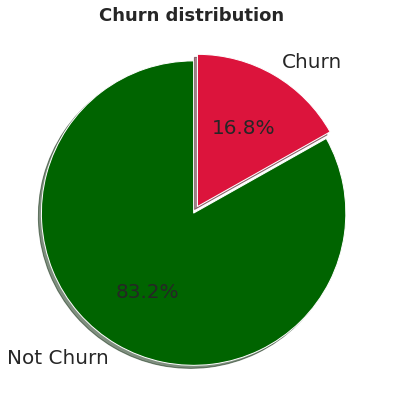

In [ ]:
labels = ['Not Churn', 'Churn']
sizes = data[target].value_counts(sort = True)
print(f'Total: {len(data)}, not_churned: {sizes[0]}, churned: {sizes[1]}')

colors = ["#006400","#dc143c"]
explode = (0.05,0) 
 
plt.figure(figsize=(7,7))
plt.suptitle("Churn distribution",y=0.9, size=18, weight='bold')
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=90, textprops={"fontsize":20})

plt.show()

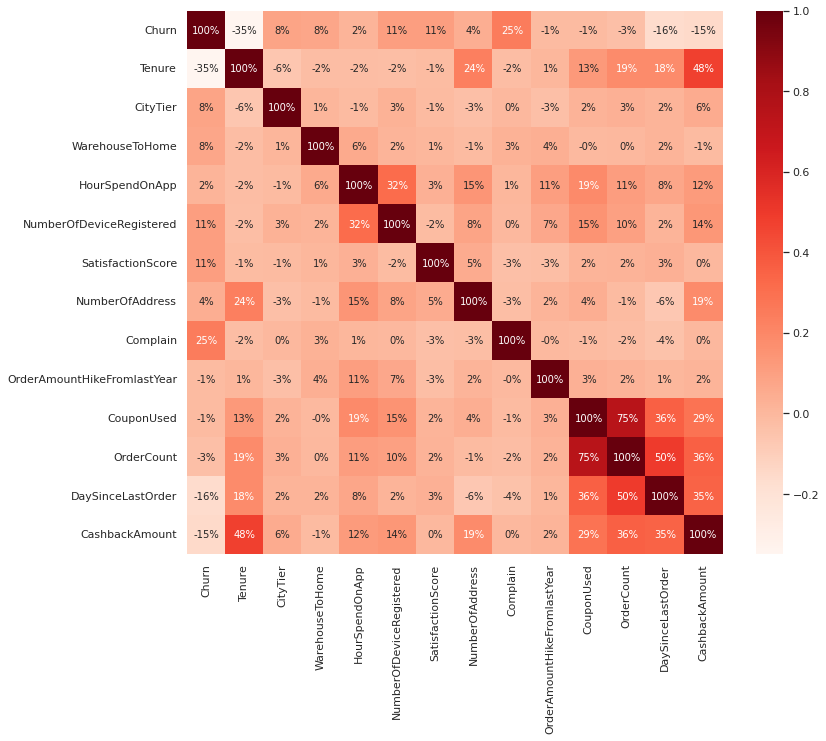

In [ ]:
ax = plt.figure(figsize=(12,10))
sns.heatmap(data.corr(),annot=True,cmap="Reds", fmt='.0%')
plt.show()

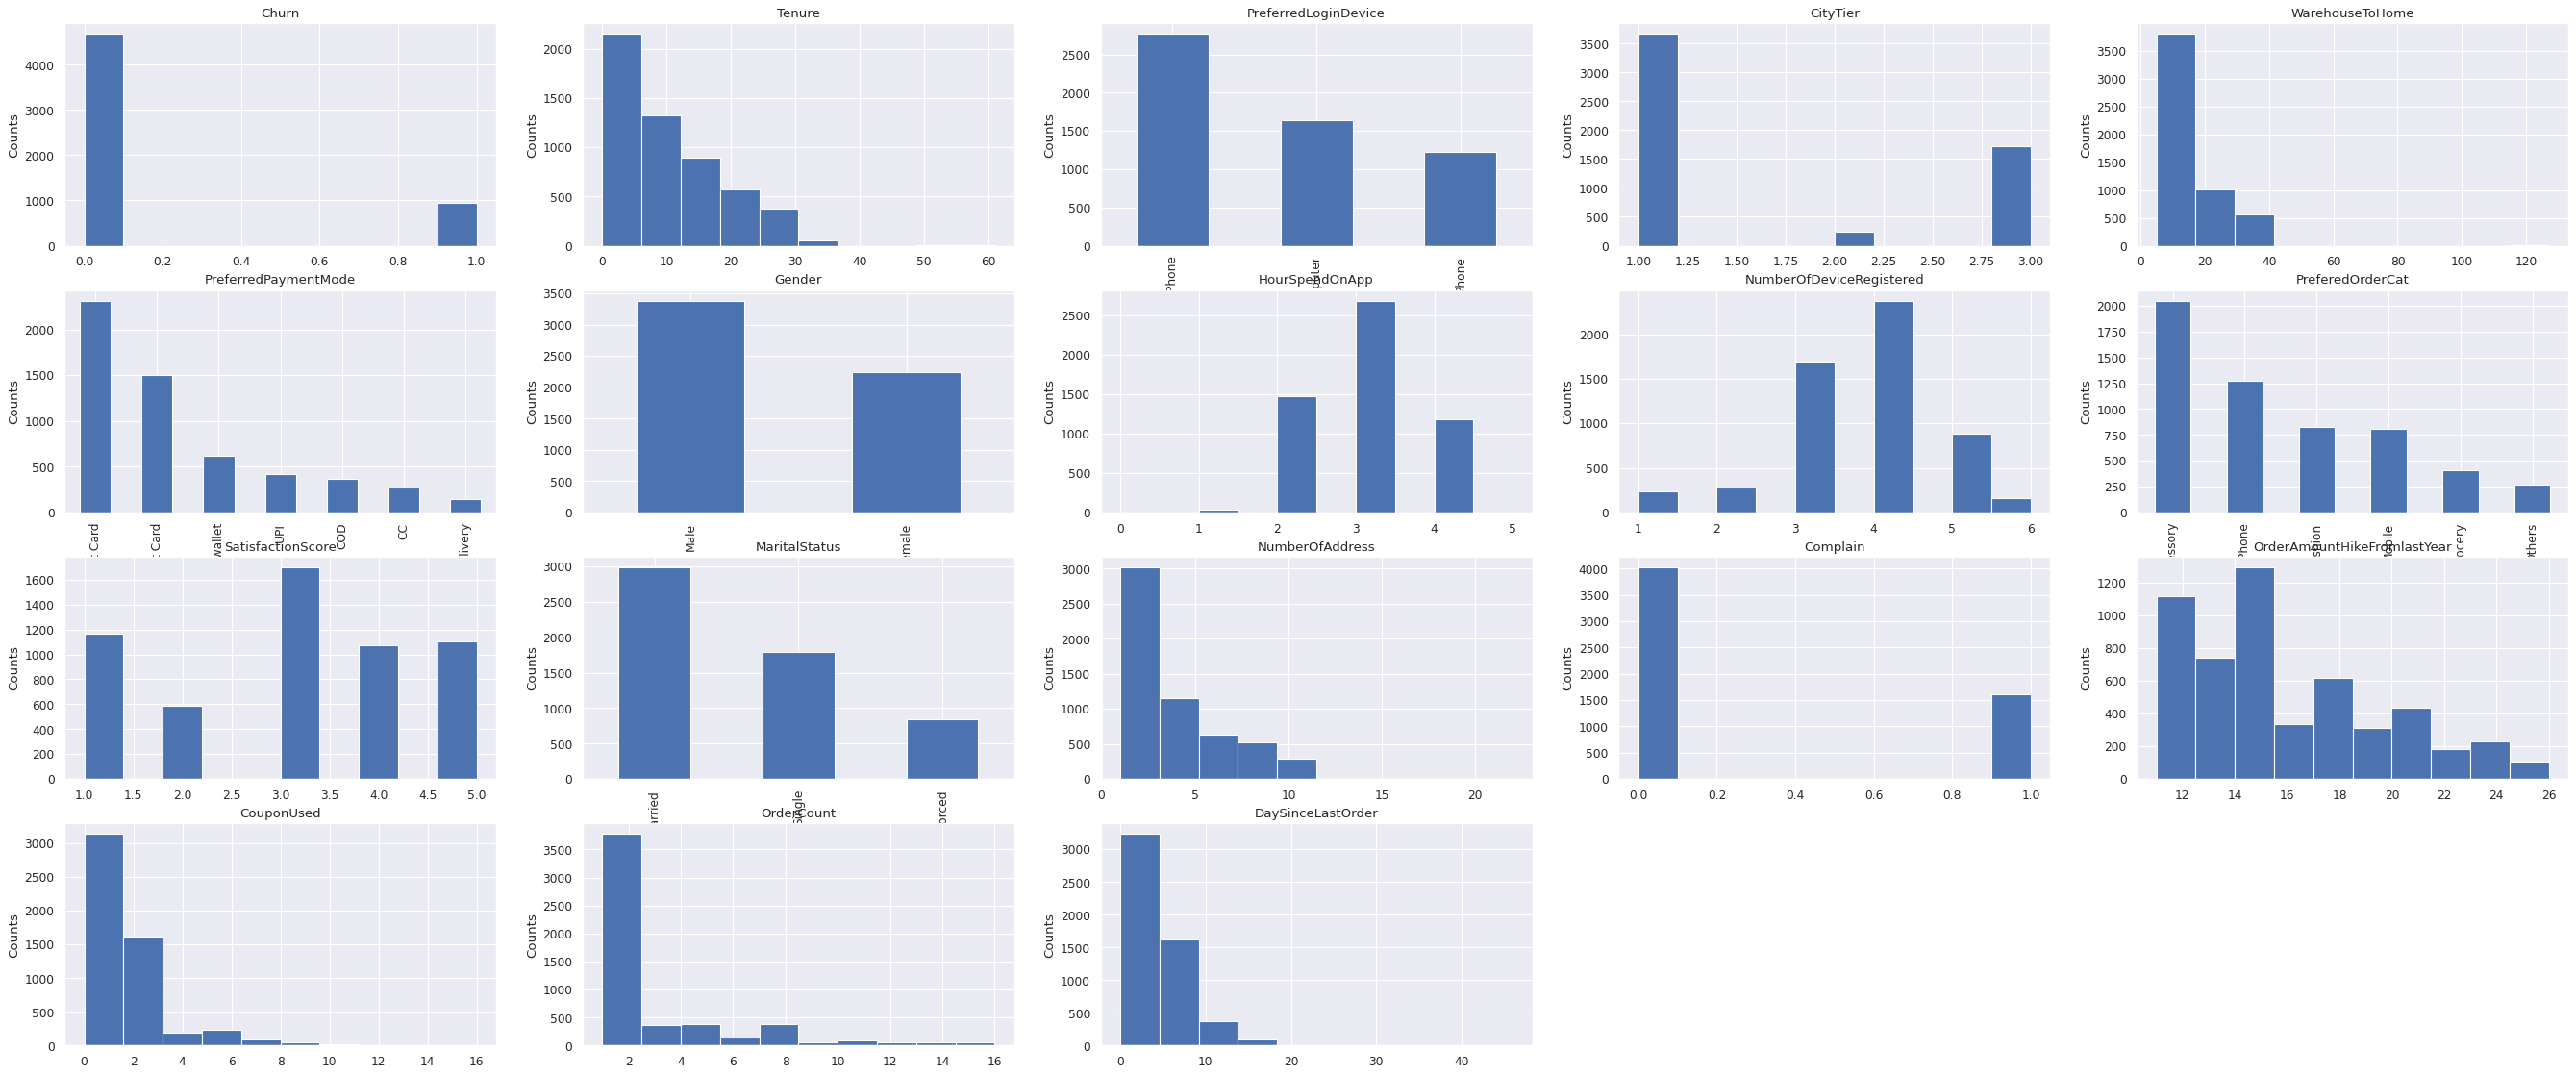

In [ ]:
barplotsColumns(data ,nLower = 1 ,nUpper = 1000)


**3.Outliers Handling**

The presence of outliers may change the mean and standard deviation of the whole dataset. With tha beeing said, it is important to remove those outliers because presence of those outliers can mislead the model. 

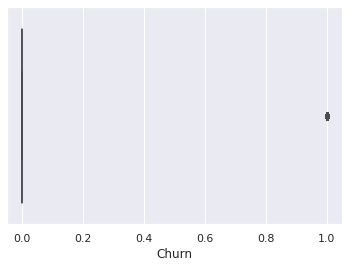

In [ ]:
sns.boxplot(x = data[target])

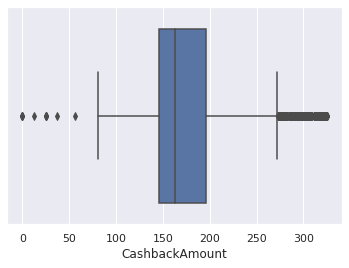

In [ ]:
sns.boxplot(x = data['CashbackAmount'])

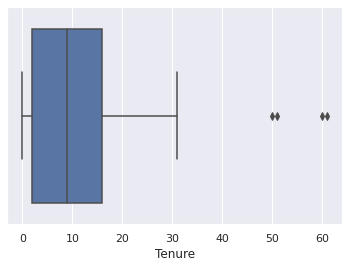

In [ ]:
sns.boxplot(x = data['Tenure'])

In [ ]:
data.query('Tenure>=50')

,Churn,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
928,0,50.0,Phone,1,6.0,Debit Card,Male,3.0,1,Laptop & Accessory,3,Divorced,1,0,24.0,1.0,2.0,8.0,149.00
2719,0,60.0,Mobile Phone,3,27.0,Debit Card,Female,3.0,3,Grocery,1,Married,5,1,13.0,NaN,1.0,0.0,278.75
3743,0,51.0,Mobile Phone,1,7.0,Debit Card,Male,4.0,2,Laptop & Accessory,3,Divorced,2,0,25.0,2.0,3.0,9.0,174.00
5534,0,61.0,Mobile Phone,3,28.0,Debit Card,Female,4.0,4,Grocery,1,Married,6,1,NaN,1.0,2.0,1.0,303.75


In [ ]:
upper, lower = outliers(data, "Tenure",4)
print("Upper limit: ", upper)
print("Lower limit: ", lower)
data = data[(data['Tenure'] >= lower) & (data['Tenure'] <= upper)]

Upper limit:  44.41886330304105
Lower limit:  -24.03906457027922


In [ ]:
data.shape

(5362, 19)

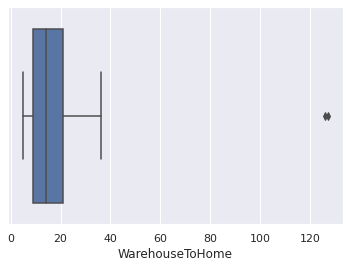

In [ ]:
sns.boxplot(x = data['WarehouseToHome'])

In [ ]:
data.query('WarehouseToHome>=50')

,Churn,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
1309,0,25.0,Computer,3,126.0,Debit Card,Male,2.0,3,Mobile,1,Married,3,0,15.0,1.0,1.0,0.0,134.82
4124,0,26.0,Computer,3,127.0,Debit Card,Male,3.0,4,Mobile Phone,1,Married,4,0,16.0,2.0,2.0,1.0,159.82


In [ ]:
data.shape

(5362, 19)

In [ ]:
upper, lower = outliers(data, "WarehouseToHome",4)
print("Upper limit: ", upper)
print("Lower limit: ", lower)
data = data[(data['WarehouseToHome'] >= lower) & (data['WarehouseToHome'] <= upper)]

Upper limit:  49.9725483155257
Lower limit:  -18.578691927343343


In [ ]:
data.shape

(5109, 19)

**4.Univariate/Bivariate Analysis: Segmentations**

We can draw further insights by segmenting numerical features against categorical ones. Let’s start off with some univariate segmentations

First of all Specifically, we’re going to segment numerical features representing SatisfactionScore, experience, complains and by the Nb of registered devices.

In [ ]:
data_UBA = data.copy()
data_UBA['status'] = ['Churn' if x==1 else 'No Churn' for x in data.Churn]

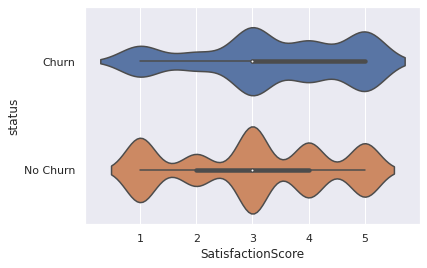

In [ ]:
sns.violinplot(y='status', x='SatisfactionScore', data=data_UBA)

We note that this satusfaction score does not reflect the chrun


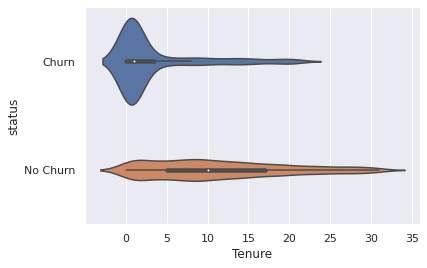

In [ ]:
sns.violinplot(y='status', x='Tenure', data=data_UBA)

We note that employee churn suddenly during the first 2 years. Those who are still around after 5 years tend to stay.

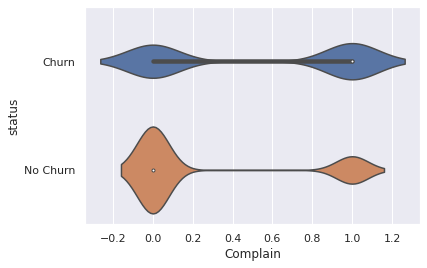

In [ ]:
sns.violinplot(y='status', x='Complain', data=data_UBA)

It appears that those who have churned tended to have complained more

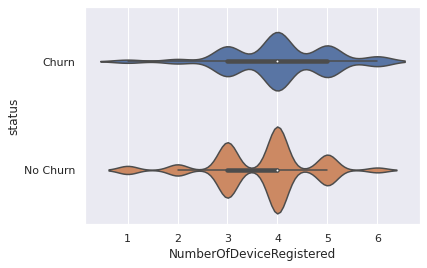

In [ ]:
sns.violinplot(y='status', x='NumberOfDeviceRegistered', data=data_UBA)

It appears that those who have churned tended to have at least 2 registered Devices

Then we deal with the categorical variables: gender

In [ ]:
cat_cols = data.dtypes[data.dtypes=='object'].keys()
cat_cols

Index(['PreferredLoginDevice', 'PreferredPaymentMode', 'Gender',
       'PreferedOrderCat', 'MaritalStatus'],
      dtype='object')

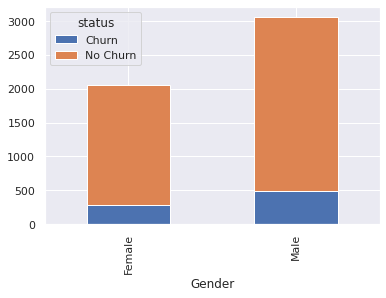

In [ ]:
counts = data_UBA.groupby(["Gender", "status"]).status.count().unstack()
counts.plot(kind='bar', stacked=True)

From the output, it seems that the ratio of customers leaving the bank among  males is slighlty higher than the females



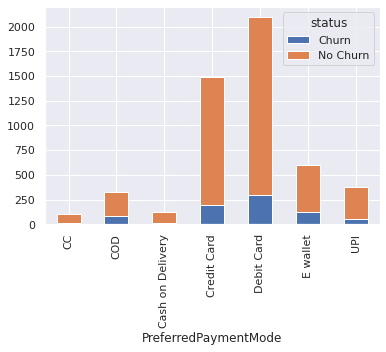

In [ ]:
counts = data_UBA.groupby(["PreferredPaymentMode", "status"]).status.count().unstack()
counts.plot(kind='bar', stacked=True)

From the output, it seems that the ratio of customers leaving the bank among  those using the COD is the highest (33%), E wallet (27%) and then CC (18%).
Those who are using credit cards are less likeley to churn (14%)

In [ ]:
df = data_UBA.groupby(["PreferredPaymentMode", "status"]).status.count().unstack()
df['perc'] = df["Churn"] / df["No Churn"]
df

status,Churn,No Churn,perc
PreferredPaymentMode,,,
CC,16,85,0.188235
COD,81,242,0.334711
Cash on Delivery,17,108,0.157407
Credit Card,191,1302,0.146697
Debit Card,292,1802,0.162042
E wallet,128,467,0.274090
UPI,58,320,0.181250


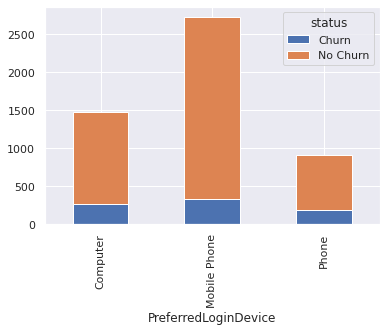

In [ ]:
counts = data_UBA.groupby(["PreferredLoginDevice", "status"]).status.count().unstack()
counts.plot(kind='bar', stacked=True)


From the output, it seems that the ratio of customers leaving the bank among  those using the mobile phone are less likely to churn 13%

In [ ]:
df = data_UBA.groupby(["PreferredLoginDevice", "status"]).status.count().unstack()
df['perc'] = df["Churn"] / df["No Churn"]
df

status,Churn,No Churn,perc
PreferredLoginDevice,,,
Computer,262,1212,0.216172
Mobile Phone,332,2397,0.138506
Phone,189,717,0.263598


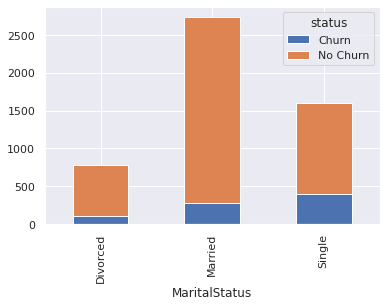

In [ ]:
counts = data_UBA.groupby(["MaritalStatus", "status"]).status.count().unstack()
counts.plot(kind='bar', stacked=True)

From the output, it seems that the ratio of customers leaving the bank among  those who are signle is the heighest 33%

In [ ]:
df = data_UBA.groupby(["MaritalStatus", "status"]).status.count().unstack()
df['perc'] = df["Churn"] / df["No Churn"]
df

status,Churn,No Churn,perc
MaritalStatus,,,
Divorced,106,669,0.158445
Married,280,2459,0.113867
Single,397,1198,0.331386


**5.Handeling missing values**

In [ ]:
#list of columns with missing value and its percentage
nan_col = data.columns[data.isnull().any()]
print(nan_col)
nulls = pd.DataFrame(data.isnull().sum().apply(lambda x: round(100*x/len(data),3)).sort_values(ascending=False))
nulls.columns = ['NaN values Percentage']
nulls.index.name = 'Feature'
nulls

Index(['HourSpendOnApp', 'OrderAmountHikeFromlastYear', 'CouponUsed',
       'OrderCount', 'DaySinceLastOrder'],
      dtype='object')


,NaN values Percentage
Feature,
DaySinceLastOrder,6.009
OrderAmountHikeFromlastYear,5.167
OrderCount,5.050
CouponUsed,4.991
HourSpendOnApp,4.991
Churn,0.000
SatisfactionScore,0.000
Complain,0.000
NumberOfAddress,0.000


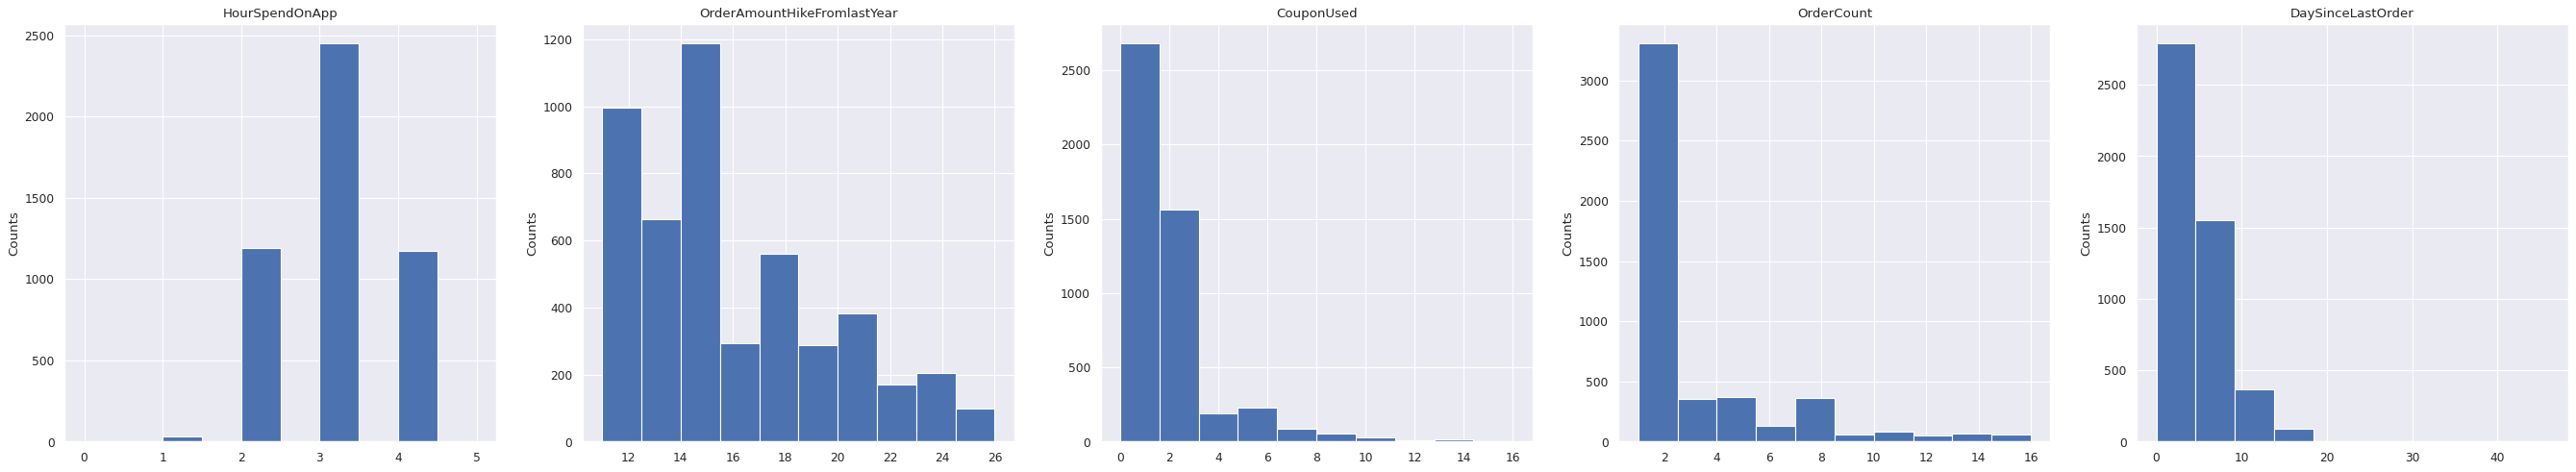

In [ ]:
features_Nan = data[data.columns[data.isnull().any()]]
barplotsColumns(features_Nan,nLower = 1,nUpper = features_Nan.nunique().max()+1)

Obviously, features with missing values are all numerical features.
Since we have eliminated the outliers, we can fill in with the mean values (otherwise the median would be a better solution)

In [ ]:
data = data.reset_index(drop=True)

In [ ]:
data[nan_col]

,HourSpendOnApp,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder
0,3.0,11.0,1.0,1.0,5.0
1,2.0,23.0,0.0,1.0,3.0
2,NaN,11.0,1.0,1.0,3.0
3,3.0,22.0,4.0,6.0,7.0
4,NaN,14.0,0.0,1.0,2.0
...,...,...,...,...,...
5104,3.0,18.0,1.0,2.0,4.0
5105,3.0,16.0,1.0,2.0,NaN
5106,3.0,21.0,1.0,2.0,4.0
5107,4.0,15.0,2.0,2.0,9.0


In [ ]:
from sklearn.impute import SimpleImputer
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_mean.fit(data[nan_col])

SimpleImputer()

In [ ]:
imp_mean.transform(data[nan_col])
filling_features = pd.DataFrame(imp_mean.transform(data[nan_col]))
filling_features.columns = data[nan_col].columns
data[nan_col] = filling_features

In [ ]:
data[nan_col]

,HourSpendOnApp,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder
0,3.000000,11.0,1.0,1.0,5.000000
1,2.000000,23.0,0.0,1.0,3.000000
2,2.981665,11.0,1.0,1.0,3.000000
3,3.000000,22.0,4.0,6.0,7.000000
4,2.981665,14.0,0.0,1.0,2.000000
...,...,...,...,...,...
5104,3.000000,18.0,1.0,2.0,4.000000
5105,3.000000,16.0,1.0,2.0,4.791129
5106,3.000000,21.0,1.0,2.0,4.000000
5107,4.000000,15.0,2.0,2.0,9.000000


**4.Feature Engineering**

In [ ]:
#categorial and numerical Features
numeric_features = data.select_dtypes(include=[np.number]).columns
categorical_features = data.select_dtypes(exclude=[np.number]).columns

In [ ]:
categorical_features

Index(['PreferredLoginDevice', 'PreferredPaymentMode', 'Gender',
       'PreferedOrderCat', 'MaritalStatus'],
      dtype='object')

In [ ]:
data[categorical_features].head()

,PreferredLoginDevice,PreferredPaymentMode,Gender,PreferedOrderCat,MaritalStatus
0,Mobile Phone,Debit Card,Female,Laptop & Accessory,Single
1,Phone,Debit Card,Male,Laptop & Accessory,Single
2,Phone,CC,Male,Mobile,Single
3,Computer,Debit Card,Female,Mobile Phone,Single
4,Phone,E wallet,Male,Mobile,Divorced


In [ ]:
data["MaritalStatus"].unique()

array(['Single', 'Divorced', 'Married'], dtype=object)

In [ ]:
# import ordinal encoder from sklearn
ord_enc = OrdinalEncoder()
# Transform the data
data[categorical_features] = ord_enc.fit_transform(data[categorical_features])

In [ ]:
data[categorical_features].head()

,PreferredLoginDevice,PreferredPaymentMode,Gender,PreferedOrderCat,MaritalStatus
0,1.0,4.0,0.0,2.0,2.0
1,2.0,4.0,1.0,2.0,2.0
2,2.0,0.0,1.0,3.0,2.0
3,0.0,4.0,0.0,4.0,2.0
4,2.0,5.0,1.0,3.0,0.0


**6.   Feature selection** : Removing both constant and quasi-constant features

In [ ]:
var_thr = VarianceThreshold(threshold = 0.5) 
var_thr.fit(data)
var_thr.get_support()

array([False,  True, False,  True,  True,  True, False, False,  True,
        True,  True, False,  True, False,  True,  True,  True,  True,
        True])

In [ ]:
def split(df,label):
    X_tr, X_te, Y_tr, Y_te = train_test_split(df, label, test_size=0.25, random_state=42)
    return X_tr, X_te, Y_tr, Y_te


from sklearn.feature_selection import VarianceThreshold
def variance_threshold(df,th):
    var_thres=VarianceThreshold(threshold=th)
    var_thres.fit(df)
    new_cols = var_thres.get_support()
    return df.iloc[:,new_cols]
    

from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, cross_val_score

classifiers = ['LinearSVM', 
               'Logistic',  
                'DecisionTree', 
               'RandomForest',  
               'KNeighbors',]

models = [svm.SVC(kernel='linear'),
          LogisticRegression(max_iter = 300),
          DecisionTreeClassifier(random_state=0),
          RandomForestClassifier(n_estimators=50, random_state=0),
          KNeighborsClassifier()]

def acc_score(df,label):
    Score = pd.DataFrame({"Classifier":classifiers})
    j = 0
    acc = []
    X_train, X_test, Y_train, Y_test = train_test_split(df, label, test_size=0.33, random_state=1)
    for i in models:
        model = i
        model.fit(X_train,Y_train)
        predictions = model.predict(X_test)
        acc.append(accuracy_score(Y_test,predictions))
        j = j+1     
    Score["Accuracy"] = acc
    Score.sort_values(by="Accuracy", ascending=False,inplace = True)
    Score.reset_index(drop=True, inplace=True)
    return Score

def acc_score_thr(df,label,thr_list):
    Score = pd.DataFrame({"Classifier":classifiers})
    for k in range(len(thr_list)):
        df2 = variance_threshold(df,thr_list[k])
        X_train,X_test,Y_train,Y_test = split(df2,label)
        j = 0
        acc = []
        for i in models:
            model = i
            model.fit(X_train,Y_train)
            predictions = model.predict(X_test)
            acc.append(accuracy_score(Y_test,predictions))
            j = j+1  
        feat = str(thr_list[k])
        Score[feat] = acc
    return Score

        
def plot2(df,l1,l2,p1,p2,c = "b"):
    feat = []
    feat = df.columns.tolist()
    feat = feat[1:]
    plt.figure(figsize = (16, 18))
    for j in range(0,df.shape[0]):
        value = []
        k = 0
        for i in range(1,len(df.columns.tolist())):
            value.append(df.iloc[j][i])
        plt.subplot(4, 4,j+1)
        ax = sns.pointplot(x=feat, y=value,color = c )
        plt.text(p1,p2,df.iloc[j][0])
        plt.xticks(rotation=90)
        ax.set(ylim=(l1,l2))
        k = k+1
        

def highlight_max(data, color='aquamarine'):
    attr = 'background-color: {}'.format(color)
    if data.ndim == 1:  
        is_max = data == data.max()
        return [attr if v else '' for v in is_max]
    else: 
        is_max = data == data.max().max()
        return pd.DataFrame(np.where(is_max, attr, ''),
                            index=data.index, columns=data.columns)

In [ ]:
data_bc = data

In [ ]:
label_bc = data_bc["Churn"]

In [ ]:
data_bc.shape

(5109, 19)

In [ ]:
score1 = acc_score(data_bc,label_bc)
score1

,Classifier,Accuracy
0,LinearSVM,1.000000
1,Logistic,1.000000
2,DecisionTree,1.000000
3,RandomForest,1.000000
4,KNeighbors,0.872479


In [ ]:
threshold_bc = [0.1,0.2,0.3,0.4,0.5]
classifiers = score1["Classifier"].tolist()
score_bc = acc_score_thr(data_bc,label_bc,threshold_bc)
score_bc.style.apply(highlight_max, subset = score_bc.columns[1:], axis=None)

,Classifier,0.1,0.2,0.3,0.4,0.5
0,LinearSVM,1.000000,0.892019,0.852113,0.852113,0.852113
1,Logistic,1.000000,0.897496,0.882629,0.882629,0.875587
2,DecisionTree,1.000000,0.961659,0.959311,0.959311,0.941315
3,RandomForest,1.000000,0.966354,0.965571,0.965571,0.961659
4,KNeighbors,0.891236,0.882629,0.881064,0.881064,0.881847


## **II - Modeling**

In [ ]:
cols = ['Tenure', 'PreferredLoginDevice', 'CityTier',
       'WarehouseToHome', 'PreferredPaymentMode', 'Gender', 'HourSpendOnApp',
       'NumberOfDeviceRegistered', 'PreferedOrderCat', 'SatisfactionScore',
       'MaritalStatus', 'NumberOfAddress', 'Complain',
       'OrderAmountHikeFromlastYear', 'CouponUsed', 'OrderCount',
       'DaySinceLastOrder', 'CashbackAmount']

In [ ]:
churns = data.Churn

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data[cols], churns.loc[data.index], test_size=0.33, random_state=1)

In [ ]:
len(y_train)

3423

**1. Knn**

              precision    recall  f1-score   support

           0       0.89      0.96      0.92      1410
           1       0.68      0.38      0.49       276

    accuracy                           0.87      1686
   macro avg       0.78      0.67      0.71      1686
weighted avg       0.85      0.87      0.85      1686

[[1359   51]
 [ 170  106]]
0.868920521945433


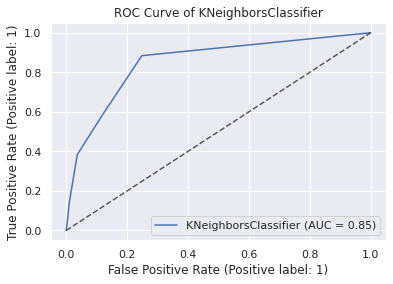

In [ ]:
from sklearn.metrics import plot_roc_curve,plot_confusion_matrix,accuracy_score,confusion_matrix

knn = KNeighborsClassifier(n_neighbors=5).fit(X_train,y_train)
print(classification_report(y_test, knn.predict(X_test)))
print(confusion_matrix(y_test, knn.predict(X_test)))
print(accuracy_score(y_test, knn.predict(X_test)))
knn_disp = plot_roc_curve(knn, X_test, y_test)
plt.title("ROC Curve of {}".format(type(knn).__name__))
plt.plot([0,1],[0,1],"--",color="k",alpha=0.7)
plt.show()

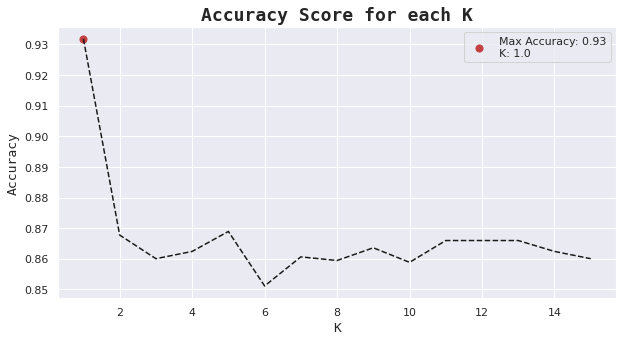

In [ ]:
k_max = 15
acc = [[],[]]
for k in range(1,k_max+1):
    mdl = KNeighborsClassifier(n_neighbors=k).fit(X_train,y_train)
    pred = mdl.predict(X_test)
    acc[0].append(k)
    acc[1].append(accuracy_score(y_test, pred)) 
acc = np.array(acc)
max_acc_k = acc[1].argmax()
plt.figure(figsize=(10,5))
plt.plot(acc[0],acc[1], color='k', ls="--")
plt.scatter(x=acc[0][max_acc_k], y=acc[1][max_acc_k],s=50, label="Max Accuracy: {}\nK: {}".format(round(acc[1][max_acc_k],2),
                                                                                                 acc[0][max_acc_k]), color='#c24040')
plt.legend()
plt.grid(True)
plt.title("Accuracy Score for each K" , size=18, fontweight='bold', fontfamily='monospace')
plt.xlabel("K", size=13, fontweight='light', fontfamily='monospace')
plt.ylabel('Accuracy', size=13, fontweight='light', fontfamily='monospace')
plt.show()

**2. Logistic regression**

Check if conditions for using Logistic Regression are met. For this Purpose, the Correlation between every Variables(Features) must be low

In [ ]:
data_LR = data.copy()

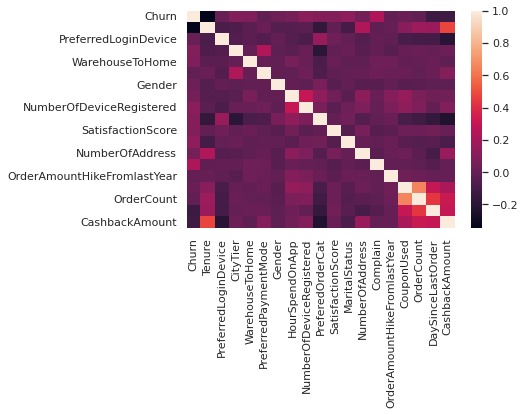

In [ ]:
corr=data_LR.corr()
sns.heatmap(corr)
plt.show()

In [ ]:
data.columns

Index(['Churn', 'Tenure', 'PreferredLoginDevice', 'CityTier',
       'WarehouseToHome', 'PreferredPaymentMode', 'Gender', 'HourSpendOnApp',
       'NumberOfDeviceRegistered', 'PreferedOrderCat', 'SatisfactionScore',
       'MaritalStatus', 'NumberOfAddress', 'Complain',
       'OrderAmountHikeFromlastYear', 'CouponUsed', 'OrderCount',
       'DaySinceLastOrder', 'CashbackAmount'],
      dtype='object')

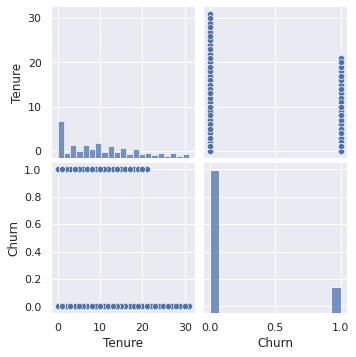

In [ ]:
sns.pairplot(data_LR, vars=["Tenure","Churn"])
plt.show()
#Not necessarily the case

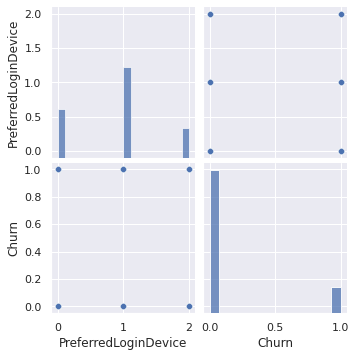

In [ ]:
sns.pairplot(data_LR, vars=["PreferredLoginDevice","Churn"])
plt.show()
#Not necessarily the case

In [ ]:
# fit multiple polynomial features
degrees = [1, 2, 3]

y_train_pred = np.zeros((len(X_train), len(degrees)))
y_test_pred = np.zeros((len(X_test), len(degrees)))

In [ ]:
models = list()
for i, degree in enumerate(degrees):
    model = make_pipeline(PolynomialFeatures(degree), LogisticRegression())
    model.fit(X_train, y_train)
    # predict on test and train data
    # store the predictions of each degree in the corresponding column
    y_train_pred[:, i] = model.predict(X_train)
    y_test_pred[:, i] = model.predict(X_test)
    models.append(model)

In [ ]:
X_train.shape,y_train.shape

((3423, 18), (3423,))

              precision    recall  f1-score   support

           0       0.90      0.97      0.93      1410
           1       0.73      0.44      0.55       276

    accuracy                           0.88      1686
   macro avg       0.81      0.71      0.74      1686
weighted avg       0.87      0.88      0.87      1686

[[1365   45]
 [ 154  122]]
0.8819691577698695


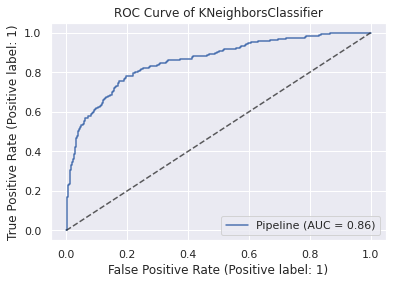

              precision    recall  f1-score   support

           0       0.90      0.97      0.93      1410
           1       0.75      0.45      0.56       276

    accuracy                           0.88      1686
   macro avg       0.82      0.71      0.75      1686
weighted avg       0.88      0.88      0.87      1686

[[1369   41]
 [ 153  123]]
0.8849347568208779


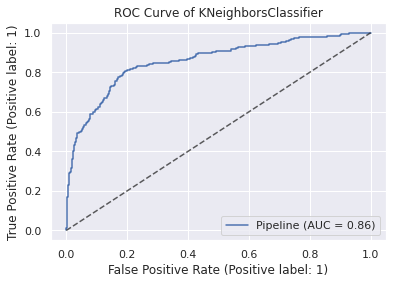

              precision    recall  f1-score   support

           0       0.90      0.96      0.93      1410
           1       0.70      0.44      0.54       276

    accuracy                           0.88      1686
   macro avg       0.80      0.70      0.73      1686
weighted avg       0.86      0.88      0.86      1686

[[1357   53]
 [ 155  121]]
0.8766310794780545


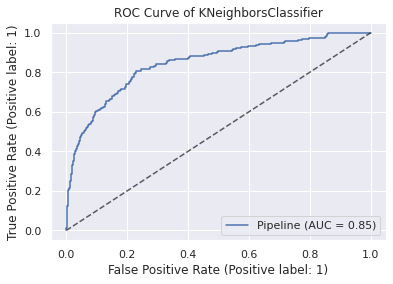

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

for i, degree in enumerate(degrees):
  print(classification_report(y_test, y_test_pred[:, i]))
  print(confusion_matrix(y_test, y_test_pred[:, i]))
  print(accuracy_score(y_test, y_test_pred[:, i]))
  disp = plot_roc_curve(models[i], X_test, y_test)
  plt.title("ROC Curve of {}".format(type(knn).__name__))
  plt.plot([0,1],[0,1],"--",color="k",alpha=0.7)
  plt.show()

**3.Random Forest**

In [ ]:
# importing Libraries:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor

In [ ]:
#Regression Tree
DTC = DecisionTreeClassifier(max_depth=7,random_state=33)
DTC.fit(X_train, y_train)
predicted_labels = DTC.predict(X_test)

              precision    recall  f1-score   support

           0       0.96      0.99      0.98      1410
           1       0.92      0.82      0.87       276

    accuracy                           0.96      1686
   macro avg       0.94      0.90      0.92      1686
weighted avg       0.96      0.96      0.96      1686

[[1391   19]
 [  51  225]]
0.9584816132858838


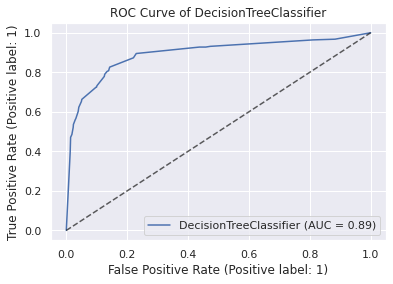

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print(classification_report(y_test, predicted_labels))
print(confusion_matrix(y_test, predicted_labels))
print(accuracy_score(y_test, predicted_labels))
disp = plot_roc_curve(DTC, X_test, y_test)
plt.title("ROC Curve of {}".format(type(DTC).__name__))
plt.plot([0,1],[0,1],"--",color="k",alpha=0.7)
plt.show()

In [ ]:
#Random Forest
RFC = RandomForestClassifier(n_estimators=200, random_state=0)
RFC.fit(X_train, y_train)
predicted_labels = RFC.predict(X_test)

              precision    recall  f1-score   support

           0       0.96      0.99      0.98      1410
           1       0.92      0.82      0.87       276

    accuracy                           0.96      1686
   macro avg       0.94      0.90      0.92      1686
weighted avg       0.96      0.96      0.96      1686

[[1391   19]
 [  51  225]]
0.9584816132858838


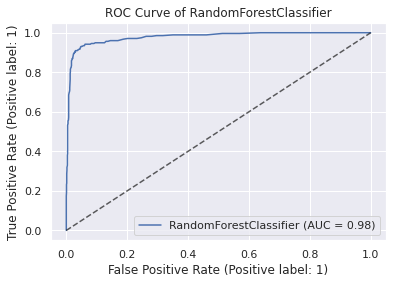

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print(classification_report(y_test, predicted_labels))
print(confusion_matrix(y_test, predicted_labels))
print(accuracy_score(y_test, predicted_labels))
disp = plot_roc_curve(RFC, X_test, y_test)
plt.title("ROC Curve of {}".format(type(RFC).__name__))
plt.plot([0,1],[0,1],"--",color="k",alpha=0.7)
plt.show()

**4.Xgboost (Extreme Gradient Boosting )**

In [ ]:
XGBC = xgb.XGBClassifier()
XGBC.fit(X_train,y_train)
predict_y = XGBC.predict(X_test)

              precision    recall  f1-score   support

           0       0.96      0.99      0.98      1410
           1       0.92      0.82      0.87       276

    accuracy                           0.96      1686
   macro avg       0.94      0.90      0.92      1686
weighted avg       0.96      0.96      0.96      1686

[[1391   19]
 [  51  225]]
0.9584816132858838


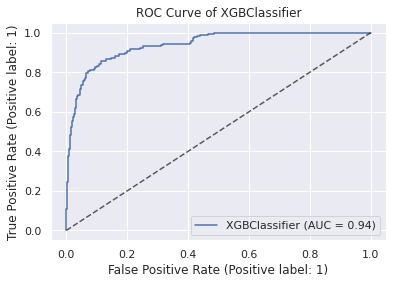

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print(classification_report(y_test, predicted_labels))
print(confusion_matrix(y_test, predicted_labels))
print(accuracy_score(y_test, predicted_labels))
disp = plot_roc_curve(XGBC, X_test, y_test)
plt.title("ROC Curve of {}".format(type(XGBC).__name__))
plt.plot([0,1],[0,1],"--",color="k",alpha=0.7)
plt.show()

**5.Gradient Boosting**

In [ ]:
gbc  = GradientBoostingClassifier(n_estimators=100)
gbc .fit(X_train,y_train)
predict_y = gbc.predict(X_test)

              precision    recall  f1-score   support

           0       0.96      0.99      0.98      1410
           1       0.92      0.82      0.87       276

    accuracy                           0.96      1686
   macro avg       0.94      0.90      0.92      1686
weighted avg       0.96      0.96      0.96      1686

[[1391   19]
 [  51  225]]
0.9584816132858838


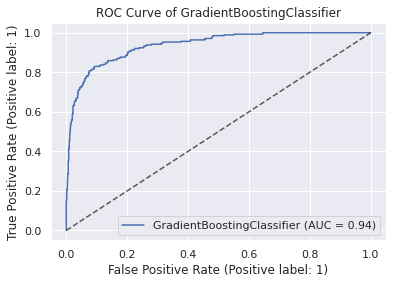

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print(classification_report(y_test, predicted_labels))
print(confusion_matrix(y_test, predicted_labels))
print(accuracy_score(y_test, predicted_labels))
disp = plot_roc_curve(gbc , X_test, y_test)
plt.title("ROC Curve of {}".format(type(gbc ).__name__))
plt.plot([0,1],[0,1],"--",color="k",alpha=0.7)
plt.show()

**6.Neural Network**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , Activation
from tensorflow.keras.utils import to_categorical

In [ ]:
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

In [ ]:
X_train = np.array(X_train)

In [ ]:
model = Sequential()

model.add(Dense(64,input_shape=X_train[0].shape,activation="sigmoid"))

model.add(Dense(128,activation="relu"))

model.add(Dense(64,activation="relu"))

model.add(Dense(2,activation="softmax"))

model.compile(loss="binary_crossentropy",optimizer="adam",metrics=["acc"])

In [ ]:
history = model.fit(X_train,y_train_cat,batch_size=32,epochs=20,validation_data=(np.array(X_test), y_test_cat))

Epoch 1/20
107/107 [==============================] - 2s 9ms/step - loss: 0.3933 - acc: 0.8519 - val_loss: 0.3685 - val_acc: 0.8363
Epoch 2/20
107/107 [==============================] - 1s 6ms/step - loss: 0.3186 - acc: 0.8633 - val_loss: 0.3270 - val_acc: 0.8594
Epoch 3/20
107/107 [==============================] - 1s 6ms/step - loss: 0.2887 - acc: 0.8852 - val_loss: 0.3138 - val_acc: 0.8766
Epoch 4/20
107/107 [==============================] - 1s 6ms/step - loss: 0.2782 - acc: 0.8902 - val_loss: 0.2979 - val_acc: 0.8837
Epoch 5/20
107/107 [==============================] - 1s 6ms/step - loss: 0.2772 - acc: 0.8928 - val_loss: 0.2945 - val_acc: 0.8909
Epoch 6/20
107/107 [==============================] - 1s 6ms/step - loss: 0.2731 - acc: 0.8940 - val_loss: 0.3095 - val_acc: 0.8760
Epoch 7/20
107/107 [==============================] - 1s 6ms/step - loss: 0.2622 - acc: 0.8992 - val_loss: 0.3192 - val_acc: 0.8802
Epoch 8/20
107/107 [==============================] - 1s 6ms/step - loss: 0.

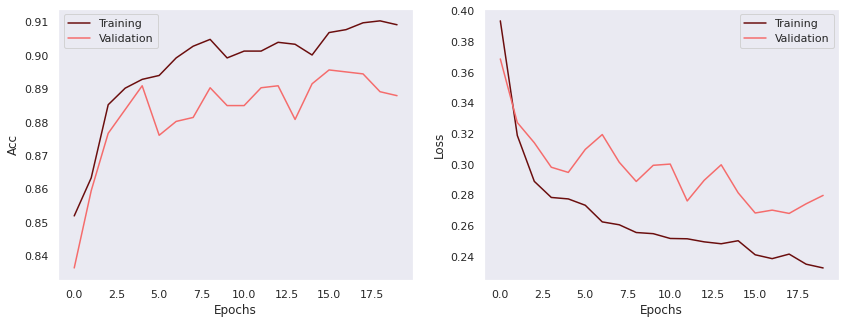

In [ ]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(history.history["acc"],color='#6b0e0e')
plt.plot(history.history["val_acc"],color='#f56c6c')
plt.xlabel("Epochs")
plt.ylabel("Acc")
plt.legend(["Training","Validation"])
plt.grid()
plt.subplot(1,2,2)
plt.plot(history.history["loss"],color='#6b0e0e')
plt.plot(history.history["val_loss"],color='#f56c6c')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Training","Validation"])
plt.grid()
plt.show()

              precision    recall  f1-score   support

         0.0       0.90      0.97      0.94      1410
         1.0       0.77      0.45      0.57       276

    accuracy                           0.89      1686
   macro avg       0.84      0.71      0.75      1686
weighted avg       0.88      0.89      0.88      1686

[[1373   37]
 [ 152  124]]
0.8879003558718861


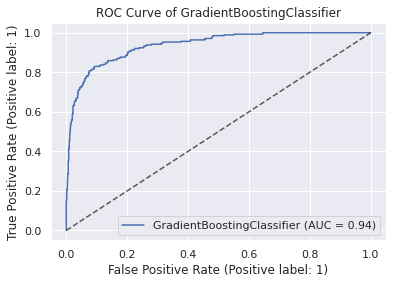

In [ ]:
pred_class = model.predict(X_test)

def toClass(pred):
    
    class_ = np.zeros(len(pred))
    for i in range(len(pred)):
        index = pred[i].argmax()
        class_[i] = index
        
    return class_

from sklearn.metrics import classification_report
print(classification_report(toClass(y_test_cat),toClass(pred_class)))

print(confusion_matrix(toClass(y_test_cat),toClass(pred_class)))
print(accuracy_score(toClass(y_test_cat),toClass(pred_class)))
disp = plot_roc_curve(gbc , X_test, y_test)
plt.title("ROC Curve of {}".format(type(gbc ).__name__))
plt.plot([0,1],[0,1],"--",color="k",alpha=0.7)
plt.show()

**III - Interprtability**

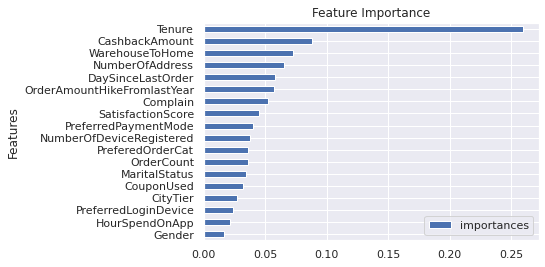

In [ ]:
df_imp = pd.DataFrame({'Features':data[cols].columns,'importances':RFC.feature_importances_})
df_imp.sort_values('importances',inplace=True)
df_imp.plot(kind='barh',y='importances',x='Features',color='b',title='Feature Importance')

The **Tnure**: the Tenure of customer in organization is by far the most important feature of the Random Forest calssifer. While the **cashbackamount**  the **WarehouseToHome** Distance in between warehouse to home of customer, came as second and third most important features. 

**Gender** and **HourSpend On App** are the least important features

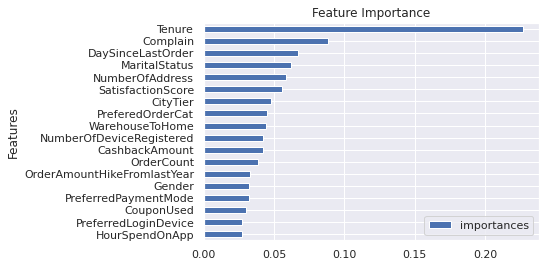

In [ ]:
df_imp = pd.DataFrame({'Features':data[cols].columns,'importances':XGBC.feature_importances_})
df_imp.sort_values('importances',inplace=True)
df_imp.plot(kind='barh',y='importances',x='Features',color='b',title='Feature Importance')

In [ ]:
! pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 564 kB 16.1 MB/s 


In [ ]:
import shap

In [ ]:
shap_values = shap.TreeExplainer(XGBC).shap_values(X_test)

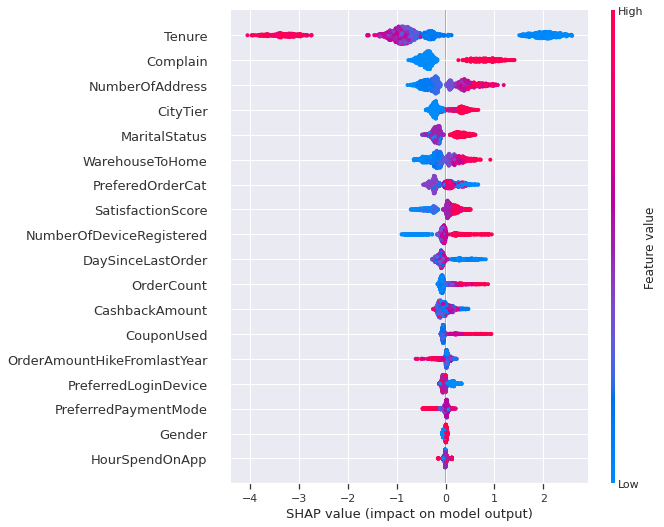

In [ ]:
shap.summary_plot(shap_values, X_test)

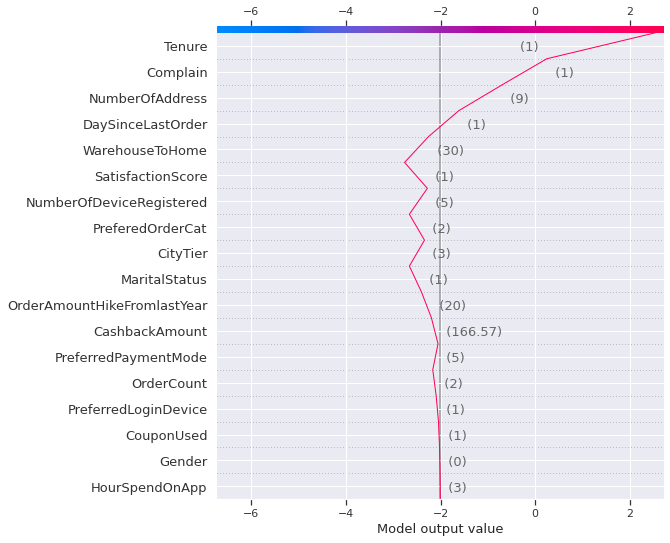

Tenure                           1.00
PreferredLoginDevice             1.00
CityTier                         3.00
WarehouseToHome                 30.00
PreferredPaymentMode             5.00
Gender                           0.00
HourSpendOnApp                   3.00
NumberOfDeviceRegistered         5.00
PreferedOrderCat                 2.00
SatisfactionScore                1.00
MaritalStatus                    1.00
NumberOfAddress                  9.00
Complain                         1.00
OrderAmountHikeFromlastYear     20.00
CouponUsed                       1.00
OrderCount                       2.00
DaySinceLastOrder                1.00
CashbackAmount                 166.57
Name: 3694, dtype: float64

In [ ]:
i = 2
X_test_ = X_test.to_numpy()
shap.decision_plot(shap.TreeExplainer(XGBC).expected_value, shap_values[i], X_test_[i], feature_names = list(X_test.columns))
X_test.iloc[i]

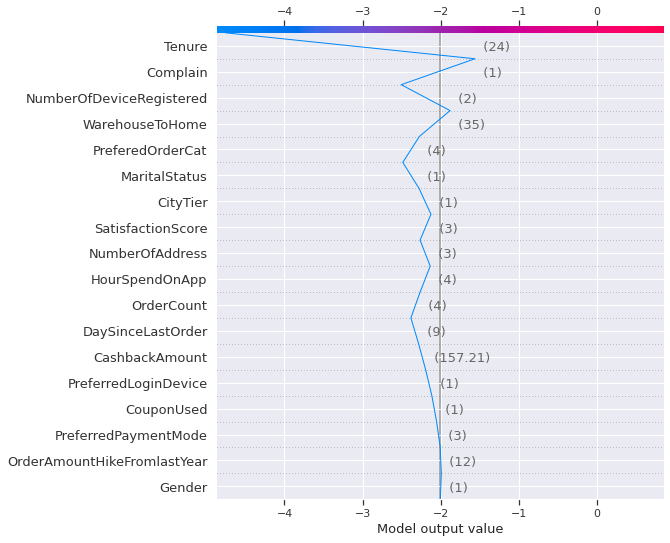

Tenure                          24.00
PreferredLoginDevice             1.00
CityTier                         1.00
WarehouseToHome                 35.00
PreferredPaymentMode             3.00
Gender                           1.00
HourSpendOnApp                   4.00
NumberOfDeviceRegistered         2.00
PreferedOrderCat                 4.00
SatisfactionScore                3.00
MaritalStatus                    1.00
NumberOfAddress                  3.00
Complain                         1.00
OrderAmountHikeFromlastYear     12.00
CouponUsed                       1.00
OrderCount                       4.00
DaySinceLastOrder                9.00
CashbackAmount                 157.21
Name: 4163, dtype: float64

In [ ]:
i = 4
X_test_ = X_test.to_numpy()
shap.decision_plot(shap.TreeExplainer(XGBC).expected_value, shap_values[i], X_test_[i], feature_names = list(X_test.columns))
X_test.iloc[i]